## 这份代码在做什么  
你要预测加州房价（回归问题） 

Baseline：只用原始特征（例如收入、房间数、纬度经度…）训练 ANN  

Enhanced：在原始特征基础上，额外加一列**“邻居平均房价”**（用地理位置找附近的房子，把这些邻居的训练房价取平均），再训练 ANN  

最后比较两者的 Test MSE，看加邻域特征有没有让模型更准。


## method  
我们的方法在 baseline ANN 的基础上加入了一个基于 “地理邻域” 的特征来显式建模空间相关性。   

虽然原始特征中已包含纬度与经度，但仅将它们作为普通数值输入会要求模型自行学习复杂的“位置—房价”非线性关系。例如靠海房价贵，经纬度接近的房子房价也接近等。  

为此，我们使用纬度/经度在空间中为每个样本定义k-近邻，并用训练集中这些邻居的目标值（房价中位数）计算邻域平均，得到新特征 Avg_Neighbor_Price。 
 
该特征作为额外输入与原始特征一同输入到同结构的 ANN 中，从而为模型提供“附近地区价格相近”的先验信息，提升对位置效应的表达能力，同时在测试集上构造该特征时仅使用训练集标签以避免数据泄露。

## 1. 导入库
numpy (np)：数学计算用的，尤其是 mean、数组索引等  
pandas (pd)：表格数据工具（DataFrame），像 Excel 那种结构  
matplotlib.pyplot (plt)：画图用（散点图、直线等）  

scikit-learn 这些：  
fetch_california_housing：下载/读取 California Housing 数据集（已经内置）  
train_test_split：把数据随机分成训练集/测试集  
StandardScaler：做标准化（让特征均值=0，方差=1），神经网络很需要这个  
MLPRegressor：前馈神经网络（ANN）做回归  
mean_squared_error：算 MSE（均方误差）  
NearestNeighbors：KNN 找最近的邻居（你用经纬度找附近地区）  

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors


## 2. 读取数据：X是特征，y是答案  
X：输入特征（每一行是一块区域的统计信息），比如：  
	•	MedInc（中位收入）  
	•	HouseAge（房龄）  
	•	AveRooms（平均房间数）  
	•	Latitude / Longitude（纬度经度）等等  

y：目标值（你要预测的真实房价标签），一个一维数组。


In [53]:
# Load data
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target  # median house value

print("Original X (head):")
print(X.head())

Original X (head):
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


## 3. 切分训练集/测试集。
test_size=0.2：20% 做测试集，80% 做训练集  
random_state=42：固定随机种子，保证你每次跑切分结果都一样（方便写报告、复现）。

#### 为什么要切分（split）  
因为你后面要做“邻居平均房价”这个特征，如果你不先 split，很容易把测试集的真实房价 y_test 偷偷用进来，这叫 data leakage（数据泄露），会让结果看起来特别好但其实作弊了。  

你现在的写法是正确的：  
✅ 先 split  
✅ 用训练集构造特征  
✅ 测试集只能“借用训练集的信息”，不能用测试集真实标签

In [54]:
# Train/test split (avoid leakage)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4.核心： 邻域特征add_graph_features  
#### 4.1 直觉理解  
房价强烈跟地理位置相关：  
你住伦敦一区，隔壁一区差不多也贵；你住郊区，隔壁郊区也差不多便宜。  
所以我们给每一条数据加一个新特征：  
Avg_Neighbor_Price = “附近 k 个邻居的平均房价”  
这样神经网络不需要自己从经纬度“猜”空间规律，我们直接把空间规律喂给它。  

#### 4.2 函数代码讲解  
见代码  

#### * 为什么要k+1  
当你给训练集加特征时：df 和 reference_df 是同一个集合。  
那 KNN 找最近邻时，第一个邻居往往就是它自己（距离=0）。  
如果你不排除它自己，那么：  
Avg_Neighbor_Price = mean( [自己的y, 邻居1的y, 邻居2的y, …] )  
这会让新特征更像“答案本身”，会让 enhanced 的效果“看起来更强”（偏虚高）。  
所以我们做：  
	•	先找 k+1 个邻居  
	•	把第一个（自己）丢掉  
	•	剩下 k 个再平均  



In [55]:
def add_graph_features(df, reference_df, reference_y, k=5, exclude_self=False):
# df：你要给谁加特征（可能是训练集，也可能是测试集）
# reference_df：你用谁来当“邻居候选池”
# reference_y：邻居候选池对应的真实房价（只能是训练集的 y）
# k=5：找 5 个最近邻
# exclude_self：是否把“自己”从邻居里排除（只对训练集需要）

    # Coordinates for neighbor search 取经纬度
    coords_ref = reference_df[['Latitude', 'Longitude']]
    coords_target = df[['Latitude', 'Longitude']]

    # If excluding self, grab one extra neighbor then drop the first one 排除自己
    n_neighbors = k + 1 if exclude_self else k

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(coords_ref)  #fit(coords_ref)：告诉 KNN，邻居候选点都在这里
    distances, indices = nbrs.kneighbors(coords_target)  #对每个目标点找最近邻返回距离和邻居在 reference_df 里的行号索引

    neighbor_prices = []
    for idx_list in indices:
        if exclude_self:
            # Drop the closest neighbor (usually itself when df == reference_df)
            idx_list = idx_list[1:]
        neighbor_prices.append(np.mean(reference_y[idx_list]))  #np.mean(...)求平均

    new_df = df.copy()  #把这个新特征加到df里
    new_df['Avg_Neighbor_Price'] = neighbor_prices
    return new_df

#### 4.3 用add_graph_features函数生成enhanced数据  
关键点：  
训练集 enhanced：邻居来自训练集本身，但排除自己（exclude_self=True）  
测试集 enhanced：邻居只能来自训练集（reference_df = X_train_raw, reference_y = y_train）  
✅ 不使用 y_test（避免泄露）

In [56]:
# Enhanced datasets
# - training enhanced excludes self
X_train_enhanced = add_graph_features(
    X_train_raw, X_train_raw, y_train, k=5, exclude_self=True
)
# - test enhanced uses ONLY training as reference (no leakage)
X_test_enhanced = add_graph_features(
    X_test_raw, X_train_raw, y_train, k=5, exclude_self=False
)

print("\nEnhanced X_train (head):")
print(X_train_enhanced.head())


Enhanced X_train (head):
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
14196  3.2596      33.0  5.017657   1.006421      2300.0  3.691814     32.71   
8267   3.8125      49.0  4.473545   1.041005      1314.0  1.738095     33.77   
17445  4.1563       4.0  5.645833   0.985119       915.0  2.723214     34.66   
14265  1.9425      36.0  4.002817   1.033803      1418.0  3.994366     32.69   
2271   3.5542      43.0  6.268421   1.134211       874.0  2.300000     36.78   

       Longitude  Avg_Neighbor_Price  
14196    -117.03              1.1614  
8267     -118.16              3.3092  
17445    -120.48              1.4200  
14265    -117.11              0.9806  
2271     -119.80              0.8496  


## 5. 定义神经网络：为什么抽成 build_mode  
这样做的意义：  
Baseline 和 Enhanced 用一模一样的网络结构，差异只来自“有没有邻域特征”。
这叫 fair comparison（公平比较）。 

参数解释：  
	•	hidden_layer_sizes=(64,32)：两层隐藏层  
	•	第一层 64 个神经元  
	•	第二层 32 个神经元  
	•	activation='relu'：激活函数 ReLU（非线性，神经网络的灵魂）  
	•	solver='adam'：优化器（训练时怎么更新参数）  
	•	alpha=1e-4：L2 正则化强度（防止过拟合的一点点约束）  
	•	max_iter=500：最多训练 500 次迭代  
	•	random_state=42：固定初始化随机性



In [57]:
#Model definition helper (same architecture for fair comparison)
def build_model(random_state=42):
    return MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        max_iter=500,
        random_state=random_state
    )

## 6.Baseline：不加邻域特征，直接训练 ANN  

#### 6.1 标准化（重要）
为什么要标准化？  
神经网络训练是靠梯度下降，如果某个特征数值范围很大（比如收入 10100），另一个很小（比如经纬度 3040），训练会很不稳定、收敛慢、甚至效果差。  

关键点：  
	•	fit_transform 只对训练集做（学习均值方差并转换）  
	•	测试集只能 transform（用训练集的均值方差来变换）  
	•	✅ 这也是避免泄露（不能用测试集统计量）


In [58]:
# BASELINE: train ANN on original X (no graph features)
scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_raw)
X_test_base_scaled = scaler_base.transform(X_test_raw)

#### 6.2 训练 + 预测 + MSE  
•fit：训练模型（学参数）  
•predict：预测测试集房价  
•MSE：衡量误差大小  
•越小越好  
•MSE 是平均平方误差：错误大的会被平方惩罚更重   


In [59]:
model_base = build_model(random_state=42)
model_base.fit(X_train_base_scaled, y_train)

y_pred_base = model_base.predict(X_test_base_scaled)
mse_base = mean_squared_error(y_test, y_pred_base)

## 7. Enhanced：加了 Avg_Neighbor_Price 再训练 ANN  
这一段和 baseline 完全同样流程，只是输入特征变成 X_train_enhanced / X_test_enhanced  

这里为什么要单独一个 scaler_enh？  
因为 enhanced 多了一列特征，维度不一样；不能用 baseline 的 scaler。

In [60]:
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enhanced)
X_test_enh_scaled = scaler_enh.transform(X_test_enhanced)

model_enh = build_model(random_state=42)
model_enh.fit(X_train_enh_scaled, y_train)

y_pred_enh = model_enh.predict(X_test_enh_scaled)
mse_enh = mean_squared_error(y_test, y_pred_enh)

## 8. 对比结果： MSE和提升百分比  
如果 enhanced 更好：mse_enh 更小 → improvement 是正数（提升%）  
如果 enhanced 更差：improvement 是负数（退步%）


In [61]:
improvement = (mse_base - mse_enh) / mse_base * 100

results = pd.DataFrame({
    "Model": ["Baseline (no graph feature)", "Enhanced (+Avg_Neighbor_Price)"],
    "Test MSE": [mse_base, mse_enh]
})

print(results)
print(f"\nRelative MSE improvement: {improvement:.2f}% (positive means enhanced is better)")


                            Model  Test MSE
0     Baseline (no graph feature)  0.274289
1  Enhanced (+Avg_Neighbor_Price)  0.180995

Relative MSE improvement: 34.01% (positive means enhanced is better)


## 9. 可视化：Actual vs Predicted 散点图看拟合质量
•	x轴：真实房价（Actual）  
•	y轴：预测房价（Predicted）  
•	红色虚线：理想情况 y=x（预测=真实）  
•	点越贴近红线 → 预测越准  
•	如果点整体偏离、或者形成弯曲 → 模型有系统性偏差  

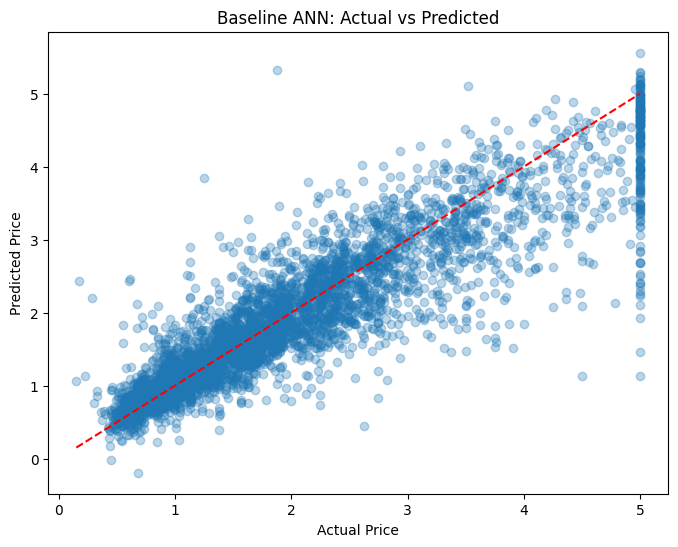

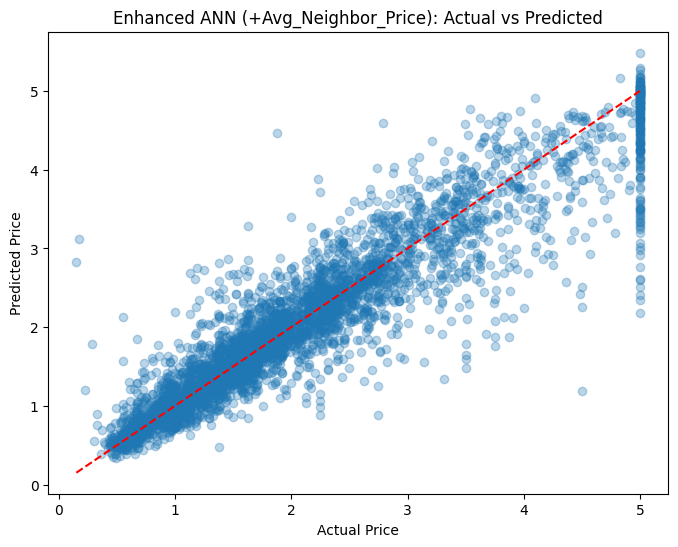

In [62]:
# Visualize (Actual vs Predicted)
def plot_actual_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    # identity line
    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(title)
    plt.show()

plot_actual_vs_pred(y_test, y_pred_base, "Baseline ANN: Actual vs Predicted")
plot_actual_vs_pred(y_test, y_pred_enh, "Enhanced ANN (+Avg_Neighbor_Price): Actual vs Predicted")

## 这张图每个东西代表什么？  
•	横轴 Actual Price：真实房价  
•	纵轴 Predicted Price：模型预测房价  
•	每一个点：测试集里的一条样本（一个地区）  
•	红色虚线：理想情况 预测房价y=真实房价y  
•	点越贴近红线 → 越准  
•	点离红线越远 → 误差越大  

关键判断规则：  
•	在线上方（点在红线之上）：预测 > 真实 → 高估  
•	在线下方（点在红线之下）：预测 < 真实 → 低估

#### Baseline plot  
1. 整体趋势是对的：点云整体沿着红线走，说明模型能抓到“房价越高，预测也越高”的趋势。  

2. 但误差会随着真实房价变大而变大：
	•	真实价格低（比如 0.5~2）的时候，点云比较紧  
	•	真实价格高（比如 3~5）的时候，点云更散  

3. 右边有一条“竖直的墙”在 Actual=5  
这通常代表：数据集的真实房价被上限截断（cap）了，很多样本的真实值都等于5（顶格）。  
于是你会看到：  
	•	真实=5 的点很多
	•	预测值却从大约 2.x 到 5.x 都有  
这类点会拉高 MSE，而且模型往往会低估顶格房价（因为它学不到“更高”到底有多高，只知道被截断了）。
这是数据本身的特点。  

#### Enhanced plot  
1. 点云更“贴红线”一些（更紧）  
尤其在 中间价位（大概 1~4），Enhanced 的点云通常会比 Baseline 更集中、更像一条带状贴着红线。  
这代表：加入邻域平均房价后，模型对“同一价位附近的样本”预测更稳定，误差变小。

2. 高价区（接近 5）的问题仍然在  
右侧 Actual=5 的竖线依旧存在，而且预测仍然分散——说明邻域特征虽然帮忙，但对顶格/极端高价的预测仍有限（原因还是 cap + 高价区噪声大）。  
	•	Enhanced 对大多数区域有改善  
	•	但对 cap 的极端高价样本改善有限 




In [63]:
cap = 5.0
mask_cap = np.isclose(y_test, cap, atol=1e-8)

print("Proportion capped at 5:", np.mean(mask_cap))

mse_cap = mean_squared_error(y_test[mask_cap], y_pred_enh[mask_cap])
mse_noncap = mean_squared_error(y_test[~mask_cap], y_pred_enh[~mask_cap])

print("MSE (capped=5):", mse_cap)
print("MSE (non-capped):", mse_noncap)

Proportion capped at 5: 0.044573643410852716
MSE (capped=5): 0.7649666716803329
MSE (non-capped): 0.15375131288458949


A noticeable vertical band at Actual = 5 indicates that the target variable is capped at 5 for a subset of observations. This censoring limits the model’s ability to learn fine-grained differences among the most expensive areas. In our test set, ___% of samples are capped at 5, and the prediction error on capped samples (MSE = ___) is substantially larger than on non-capped samples (MSE = ___). Therefore, while overall performance improves with the neighbourhood feature, predictions at the upper end remain challenging due to target censoring.  
从 Actual vs Predicted 图中可以看到在 Actual≈5 附近存在明显的竖直带，说明目标变量在最大值处存在封顶/截断。用 np.isclose 判断后，测试集中约 4.46% 的样本属于顶格（y≈5）。顶格样本的误差明显更大（MSE≈0.765），而非顶格样本误差较小（MSE≈0.154），说明模型的总体误差很大一部分来自高价端的封顶区域，高价预测依然是主要难点。

## 10. 进一步改善模型，adjust k-value

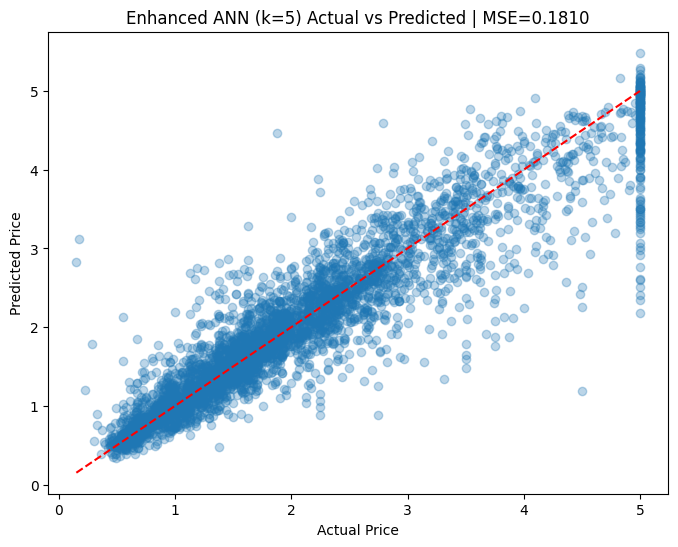

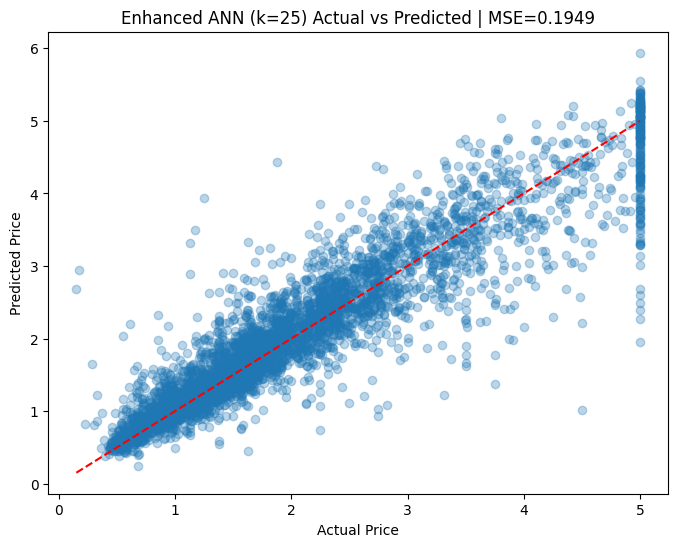

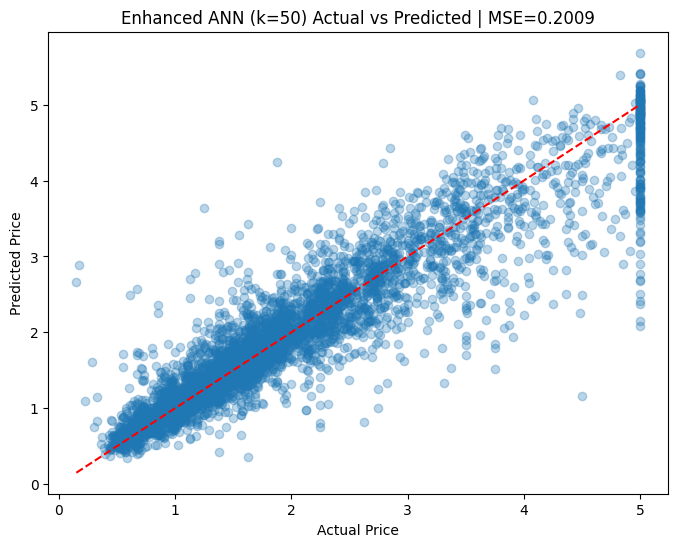

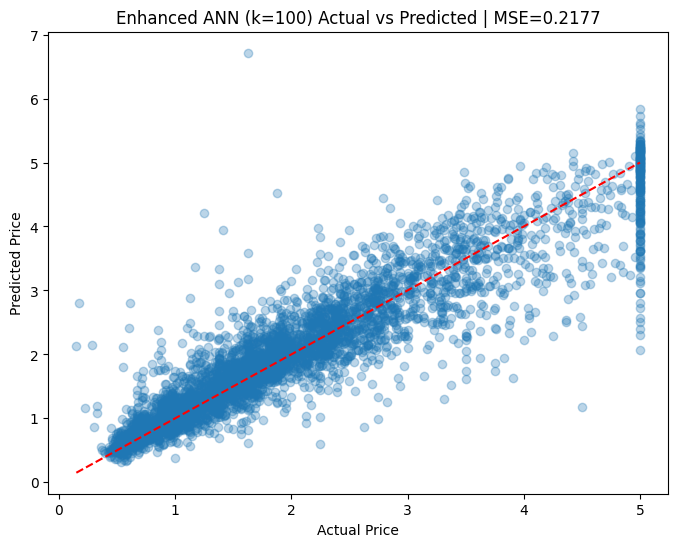

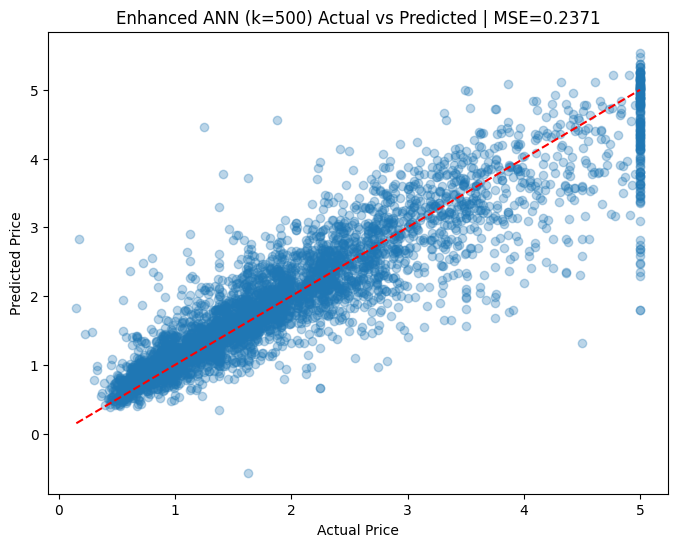

In [64]:
ks = [5, 25, 50, 100, 500]

for k in ks:
    # 1) build enhanced features for this k
    X_train_en = add_graph_features(X_train_raw, X_train_raw, y_train, k=k, exclude_self=True)
    X_test_en  = add_graph_features(X_test_raw,  X_train_raw, y_train, k=k, exclude_self=False)

    # 2) scale
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train_en)
    Xte = scaler.transform(X_test_en)

    # 3) train model
    model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu',
                         solver='adam', alpha=1e-4, max_iter=500, random_state=42)
    model.fit(Xtr, y_train)

    # 4) predict + mse
    pred = model.predict(Xte)
    mse = mean_squared_error(y_test, pred)

    # 5) scatter plot (Actual vs Predicted)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, pred, alpha=0.3)
    mn, mx = float(np.min(y_test)), float(np.max(y_test))
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Enhanced ANN (k={k}) Actual vs Predicted | MSE={mse:.4f}")
    plt.show()

#### 通过adjust k-value的发现：  
1. 存在一个“较优的 k”（通常在小 k）。测试了多个 k 值，发现模型在较小的 k（例如 5/25）时表现最好；当 k 变大时，测试误差上升。  
2. k 在中等范围变化时，点云图肉眼差别不明显。说明在该设置下模型对 k 的变化并不“极度敏感”；差异主要体现在 MSE 的小幅变化上。  
3. 当 k 很大时，Avg_Neighbor_Price 更接近一个“更大范围/更全局的平均价格”，会把局部街区差异抹平（over-smoothing）。因此邻域特征变得不够“本地”，对预测帮助变小甚至变差。

## 11. 尝试使用“多尺度 + 距离加权”的邻域特征  
现在的 Avg_Neighbor_Price 其实是：  
•	只用 一个尺度（一个 k）  
•	而且是 简单平均（不管远近）

修改为：  
•	用权重 w=1/(d+\epsilon) 做加权平均。
近的邻居权重大，远的权重小。   
•	同时算多区域价位（就是把原始代码+k set的loop code block合为一个整体的意思）


[Weighted] k=5  MSE=0.2027


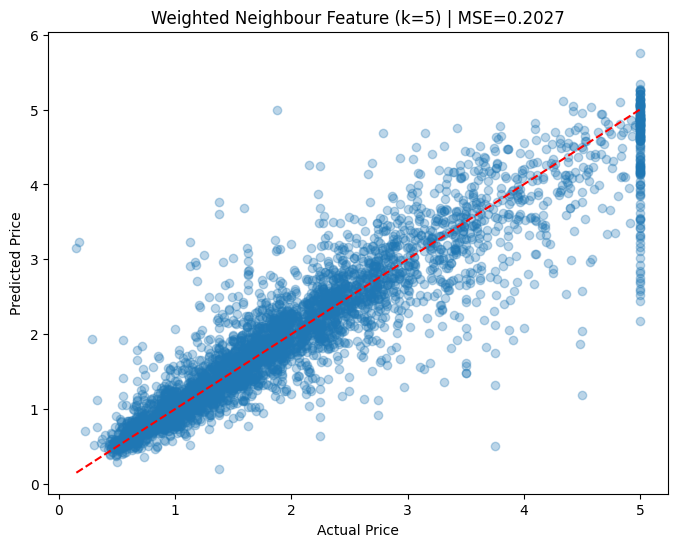

[Weighted] k=25  MSE=0.2035


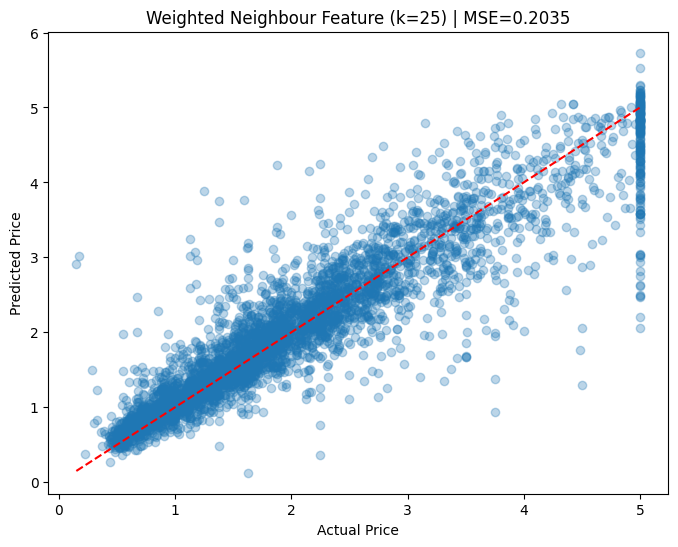

[Weighted] k=50  MSE=0.1964


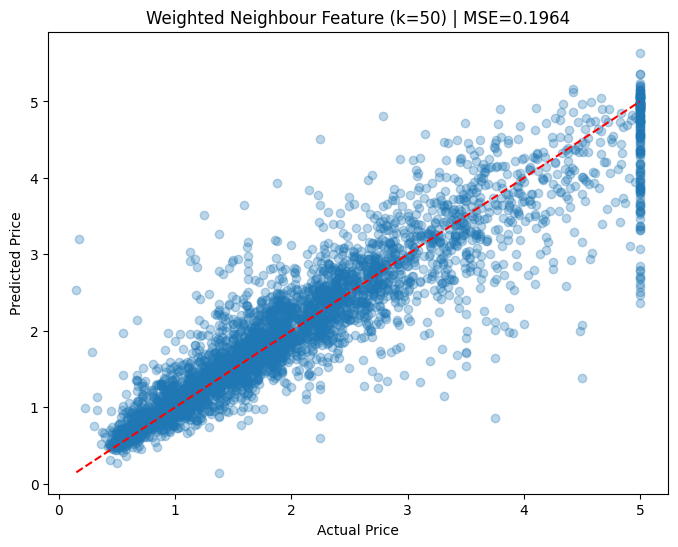

In [65]:
# =========================
# EXTRA BLOCK: Distance-weighted neighbour feature (no change to your main code)
# =========================

def add_weighted_neighbor_feature(df, reference_df, reference_y, k=5, exclude_self=False, eps=1e-6):
    coords_ref = reference_df[['Latitude', 'Longitude']]
    coords_target = df[['Latitude', 'Longitude']]

    n_neighbors = k + 1 if exclude_self else k
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(coords_ref)
    distances, indices = nbrs.kneighbors(coords_target)

    wavg_prices = []
    for dist_list, idx_list in zip(distances, indices):
        if exclude_self:
            dist_list = dist_list[1:]  # drop self
            idx_list = idx_list[1:]

        y_neighbors = reference_y[idx_list]
        w = 1.0 / (dist_list + eps)  # closer -> larger weight
        wavg = np.sum(w * y_neighbors) / np.sum(w)
        wavg_prices.append(wavg)

    new_df = df.copy()
    new_df["WAvg_Neighbor_Price"] = wavg_prices
    return new_df


# try a few k values (weighted)
ks_weighted = [5, 25, 50]

for k in ks_weighted:
    X_train_w = add_weighted_neighbor_feature(X_train_raw, X_train_raw, y_train, k=k, exclude_self=True)
    X_test_w  = add_weighted_neighbor_feature(X_test_raw,  X_train_raw, y_train, k=k, exclude_self=False)

    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train_w)
    Xte = scaler.transform(X_test_w)

    model = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        max_iter=500,
        random_state=42
    )
    model.fit(Xtr, y_train)

    pred = model.predict(Xte)
    mse = mean_squared_error(y_test, pred)
    print(f"[Weighted] k={k}  MSE={mse:.4f}")

    # point cloud
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, pred, alpha=0.3)
    mn, mx = float(np.min(y_test)), float(np.max(y_test))
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Weighted Neighbour Feature (k={k}) | MSE={mse:.4f}")
    plt.show()

#### 通过 Multi-scale, Distance-weighted Graph Features 的发现：  
分析原因A：  
•	经纬度是“平面欧氏距离”，不等于真实地理距离。NearestNeighbors 默认用欧氏距离算（lat/long 的差）。  
•	但经纬度其实是在球面上，尤其经度在不同纬度下“1度代表的距离不一样”。  
•	所以使用 1/(distance) 加权，会把这种“距离的误差”放大：权重更敏感，误差也被放大。

分析原因B：  
•	权重太尖锐（closest 1–2 个邻居影响过大）  
•	1/(d+eps) 会让最近的点权重非常大，导致：  
	•	特征变得更像“最近邻的 y”，对噪声特别敏感  
	•	一旦最近邻不是同一真实子市场（比如隔一条山/河/城市边界），就会被误导

分析原因C：
•	已经在 X 里有 Latitude/Longitude 了。ANN 已经能利用经纬度，再加一个过强的加权邻域价，会容易让模型“过度依赖邻域价”，泛化变差。

k越大MSE越小的原因分析：  
•	你用的权重一般是类似 w=1/(d+\epsilon)。
这会导致：距离最小的 1–2 个点权重巨大，远一点的点权重很小。 所以当 k 很小（比如 5）时，加权平均几乎变成：“最接近的 1–2 个邻居的价格（几乎就是它们在决定）”  
如果这些最近邻刚好是噪声点、或者处在价格跳变边界（城市边界/地形/学区），那你这个特征就会很不稳定 → MSE 高。
•	增大 k 会引入更多邻居使加权统计更平滑，从而降低方差并改善测试误差，因此在加权设置下观察到 k 越大 MSE 越小的趋势。


#### 比较两种邻域特征：  
简单平均和距离加权平均。简单平均更平滑、更抗噪，作为 ANN 输入时更稳定；距离加权更强调最近邻，信息更“尖锐”，但也更容易受距离度量误差和局部噪声影响。实验中距离加权并未带来提升，反而增加了测试误差，说明在本数据中简单平均更适合用于邻域特征。

## Discussion  
1. Enhanced 的动机与效果（baseline vs enhanced）

本项目的核心问题是：在用 ANN（MLPRegressor）预测房价时，加入“邻域/图结构”的信息是否能提高预测效果。Baseline 模型只使用原始的 8 个特征来训练，其中已经包含纬度（Latitude）和经度（Longitude）。但如果只把经纬度当作普通数值输入，神经网络需要自己去学习复杂的“位置→房价”的非线性关系，这往往比较困难。
因此我构造了 enhanced 模型：利用经纬度通过 kNN 找到每个样本的邻居，并用训练集邻居的房价均值构造新特征 Avg_Neighbor_Price，把它与原始特征一起输入 ANN。这个特征的直觉是：地理位置相近的地区通常房价也相近（空间相关性）。从结果来看，enhanced 模型在 Actual vs Predicted 点云图中整体更贴近 y=x 的参考线，并且测试集误差（MSE）相对 baseline 有所改善（Baseline MSE = ___，Enhanced MSE = ___）。这说明邻域信息能够为模型提供额外的、有用的位置信号。

2. cap=5 误差

从 Actual vs Predicted 图中可以看到在 Actual≈5 附近存在明显的竖直带，这提示目标变量在最大值处存在封顶/截断（censoring）。这种封顶会限制模型学习最高价区域的细粒度差异：因为数据把超过上限的真实价格统一记为 5，模型无法知道 5 以上到底怎么区分。
结果显示测试集中约 4.46% 的样本属于顶格，但它们的预测误差显著更大：顶格组 MSE≈0.765，而非顶格组 MSE≈0.154。这说明整体误差中有相当一部分来自高价端封顶区域，高价预测是模型最主要的难点之一，也解释了为什么图上 Actual≈5 附近点云更分散。

3. k-sweep 结论（为什么 k 太大变差）

为了进一步改进 enhanced 模型，我把邻居数 k 当成一个可调参数，测试了多个不同的 k 值。直观上，较小的 k 代表更“局部”的邻域信息，而较大的 k 会更“平滑”，更像区域平均水平。实验中，不同 k 的点云图整体形状相似，说明模型对中等范围的 k 变化并不是极度敏感；但从 MSE 数值仍能看到差异：当 k 过大时，模型误差会变高。一个合理解释是 过度平滑（over-smoothing）：当邻域范围太大，邻居点可能来自不同的城市/不同的经济区，均值会把真实的局部地段差异抹掉，使得 Avg_Neighbor_Price 的“本地信息”下降，最终影响模型泛化表现。因此较小的 k（例如 5 或 25）更像是“局部性”和“稳定性”之间的折中。

4. Weighted 尝试失败但解释合理（创新尝试）

作为额外的改进尝试，我把简单平均改成了距离加权平均：离得越近的邻居权重越大，希望更符合“越近越相关”的直觉。但实验结果显示距离加权并没有带来提升，部分设置下测试 MSE 反而更高（例如 weighted k=5 的 MSE = ___，相比 unweighted enhanced 更差）。
我认为可能有两个原因：第一，加权方法对距离度量更敏感，而这里的距离是用经纬度直接做欧氏距离近似，可能并不完全等价于真实地理距离；第二，距离加权会让特征被“最接近的少数邻居”强烈主导，一旦最近邻存在噪声或处在不同市场边界附近，加权特征就会变得不稳定，从而伤害泛化。与此同时，我也观察到在加权设置下 k 增大时误差可能下降，这与“更多邻居会让加权统计更平滑、更稳定”的解释一致。总体来说，这个实验说明“更复杂的特征不一定更好”，简单均值反而更稳健。  

5. 局限性 + future work（2–3 条即可）

本方法仍有一些局限。第一，邻域是仅基于经纬度定义的 KNN 关系，没有考虑真实地理距离、道路/地形阻隔或行政边界，这可能导致“邻居”并不总是同一房价子市场。第二，邻域特征目前只使用均值这一种统计量，可能丢失了局部波动信息；未来可以加入邻居房价的标准差、min/max 或多尺度特征（同时使用不同 k）来表达“局部地段”和“区域背景”的共同影响。第三，目标封顶（cap=5）使得最高价区间先天难评估；未来可以同时报告 MAE、或对不同价格区间分别评估，进一步分析模型在哪些区间表现更可靠。最后，当前结果基于一次 train/test split，未来可用多个随机种子重复实验以增强结论稳定性。




## 总结
这份代码主要做了三步实验，目的是看加入“邻域信息”能不能提升 ANN 的房价预测效果。  
(1) Baseline ANN（不加邻域特征）  
我先用 California Housing 数据集的原始 8 个特征训练一个 ANN 回归模型（MLPRegressor），并用测试集的 MSE 评估预测效果，同时画出 Actual vs Predicted 的点云图来直观看模型拟合情况。  

(2) Enhanced ANN：加入邻域特征（Avg_Neighbor_Price）  
因为房价和地理位置相关，我利用纬度/经度用 kNN 找每个点附近的邻居，并用训练集中这些邻居的房价平均值构造新特征 Avg_Neighbor_Price。  
为了避免 data leakage，测试集的邻域特征只用训练集的 y_train 计算，不使用 y_test。加入该特征后重新训练 ANN，并画出点云图进行对比分析（共画了多张图来观察不同设置下预测与真实值的关系）。  

(3) 改进尝试 1：调整 k（邻居数）  
我把 k 当成可调参数，测试不同 k 值（例如 k = 5, 25, 50, 100, 500），对每个 k 都重复“构造邻域特征 → 标准化 → 训练 ANN → 计算 MSE → 画点云图”，观察模型误差是否随 k 改变。整体上点云趋势差别不大，但 MSE 会随 k 出现一定变化，说明邻域范围过小/过大都可能影响特征的有效性。  

(4) 改进尝试 2：距离加权邻域均值（Weighted average）  
在原本的简单平均基础上，我进一步尝试用距离加权的方法计算邻居价格均值（离得越近权重越大），并比较其测试 MSE。结果显示距离加权在本数据上并没有带来提升，甚至在部分 k 下误差更高。我推测这是因为加权方法对距离度量更敏感，小 k 时容易被最近邻的噪声影响；当 k 增大时，加入更多邻居会让加权统计更平滑，因此观察到在加权设置下 k 越大误差可能越小的趋势。